# Black Garlic CNN Modellingh via Transfer Learning

In [15]:
import tensorflow as tf
print(tf.keras.__version__)

3.4.1


In [16]:
physical_devices = tf.config.list_physical_devices('XPU')
physical_devices

[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]

## Add functions

In [17]:
#Prep the notebook
#import necessary sources 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
from sklearn.metrics import accuracy_score

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os
import zipfile

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

run_counter=0

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, name="model"): 
    # Create the confustion matrix
    global run_counter
    run_counter=run_counter+1
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with
    
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
    
    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
    
    # Save the figure to the current working directory
    if savefig:
        fig.savefig(str(run_counter)+"_"+name+"_confusion_matrix.tiff",dpi=300, bbox_inches='tight')
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round
    
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
  
def plot_loss_curves(history,figsize=(8, 8), model_name=""):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"_loss.tiff",dpi=300,bbox_inches='tight')
    
    # Plot accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"_accuracy.tiff",dpi=300,bbox_inches='tight')

def compare_historys(original_history, new_history, initial_epochs=5, model_name=""):

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    #plt.show()
    plt.savefig(str(run_counter)+"_"+model_name+"_tuned_history.tiff",dpi=300,bbox_inches='tight')
  
def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

## Data Preparation

In [18]:

#inspect the dataset directory
walk_through_dir("black_garlic_main")

# Create training, validation and test directories
train_dir = "black_garlic_main/train/"
test_dir = "black_garlic_main/test/"
val_dir = "black_garlic_main/val/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = keras.utils.image_dataset_from_directory(directory=train_dir,
                                                      image_size=IMG_SIZE,
                                                      label_mode="categorical",
                                                      batch_size=32)
test_data = keras.utils.image_dataset_from_directory(directory=test_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=32,
                                                     shuffle=False)
val_data = keras.utils.image_dataset_from_directory(directory=val_dir,
                                                    image_size=IMG_SIZE,
                                                    batch_size=32,
                                                    label_mode="categorical",
                                                    shuffle=True)


There are 3 directories and 0 images in 'black_garlic_main'.
There are 3 directories and 0 images in 'black_garlic_main/train'.
There are 0 directories and 370 images in 'black_garlic_main/train/underaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/overaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/test'.
There are 0 directories and 20 images in 'black_garlic_main/test/underaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/overaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/val'.
There are 0 directories and 65 images in 'black_garlic_main/val/underaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/overaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/excellent'.
Found 1110 files belonging to 3 classes.
Found 6

In [19]:
#Script to generate important details and figures
res = []
def generate_details(model,test_data,history,tuned=False):
    print("Evaluating...")
    loaded_loss, loaded_accuracy = model.evaluate(test_data)
    loaded_loss, loaded_accuracy
    print("done.")
    #make predictions usind the model
    print("Predicting...")
    pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take
    print("done.")

    #save the evaluation results for tabulation
    res.append([model.name,round(loaded_loss*100,4),round(loaded_accuracy*100,4)])
    
    # Get the class predicitons of each label
    pred_classes = pred_probs.argmax(axis=1)
    
    # How do they look?
    pred_classes[:10]
    
    # make labels using unbatch
    y_labels = []
    for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
    y_labels[:10] # check what they look like (unshuffled)
    
    # Get accuracy score by comparing predicted classes to ground truth labels
    sklearn_accuracy = accuracy_score(y_labels, pred_classes)
    sklearn_accuracy
    
    # Does the evaluate method compare to the Scikit-Learn measured accuracy?
    import numpy as np
    print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")
    
    # Get the class names
    class_names = test_data.class_names
    class_names[:10]
    
    #Genrate the confusion matrix
    make_confusion_matrix(y_true=y_labels,
                          y_pred=pred_classes,
                          classes=class_names,
                          figsize=(5, 5),
                          text_size=10,
                          norm=True,#with percentage
                          savefig=True,
                          name=model.name)
    if tuned:
        #plot hystorys
        compare_historys(original_history=history[0],
                         new_history=history[1],
                         initial_epochs=history[2],
                         model_name=model.name)
    else:
        #Plot the curves
        plot_loss_curves(history[0],figsize=(6, 3), model_name=model.name)


# Setup checkpoint path
def setup_checkpoint(model_name):
    weights_checkpoint_path = "checkpoints/"+model_name+".weights.h5"
    model_checkpoint_path = "checkpoints/"+model_name+"model.keras" 
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    weights_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_checkpoint_path,
                                                             save_weights_only=True, # set to False to save the entire model
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    # Create a ModelCheckpoint callback that saves the whole model
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    return (weights_checkpoint_callback, weights_checkpoint_path)

#results printer
def show_results(results):
    all_results = pd.DataFrame(results, columns=["Model", "Loss", "Accuracy"])
    all_results.to_csv('RESULTS.csv')
    return all_results

# Model 1 EfficientNetB0

In [20]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
              
model_1.name="Model_1_EfficientNetB0"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1 = model_1.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.4759 - loss: 1.0304
Epoch 1: val_loss improved from inf to 0.64937, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.4794 - loss: 1.0271 - val_accuracy: 0.8256 - val_loss: 0.6494
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8031 - loss: 0.6508
Epoch 2: val_loss improved from 0.64937 to 0.45771, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.8036 - loss: 0.6493 - val_accuracy: 0.9231 - val_loss: 0.4577
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8865 - loss: 0.4867
Epoch 3: val_loss improved from 0.45771 to 0.36122, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.8865 - loss: 0.4859 - val_accuracy: 0.9385 - val_loss: 0.3612
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step 

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9785 - loss: 0.1500  
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -4.371007278347605e-08


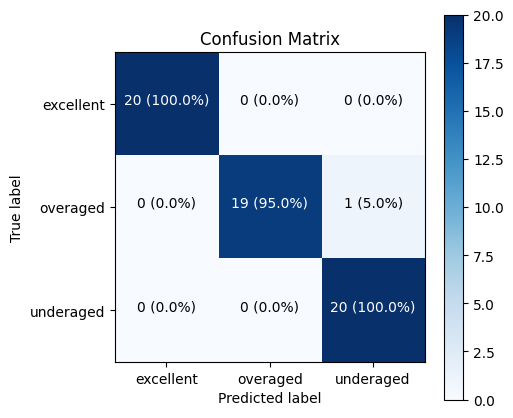

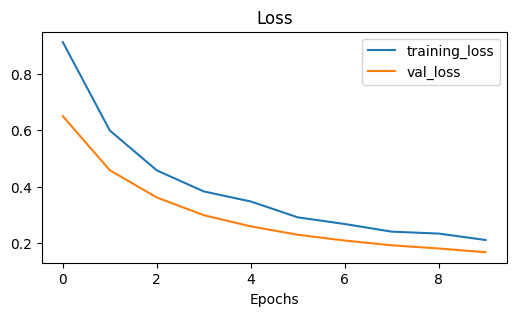

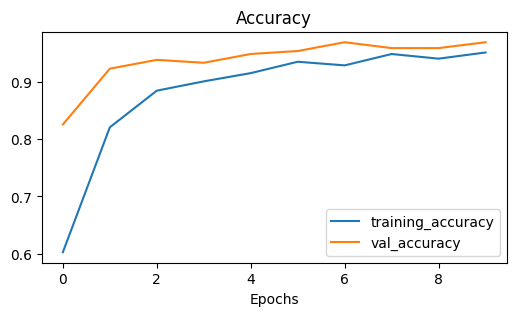

In [21]:
#Generate needed details
generate_details(model_1,test_data,[history1])

# Model 1 EfficientNetB0 with fine-tuning

In [22]:
model_1.load_weights(checkpoint_path)
model_1.layers[1].trainable = False

for layer in model_1.layers[1].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
model_1.name="Model_1_EfficientNetB0_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1_tuned = model_1.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history1.epoch[-1], 
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9287 - loss: 0.2407
Epoch 10: val_loss improved from inf to 0.11666, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.9288 - loss: 0.2399 - val_accuracy: 0.9641 - val_loss: 0.1167
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9719 - loss: 0.1204
Epoch 11: val_loss improved from 0.11666 to 0.08919, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.9718 - loss: 0.1205 - val_accuracy: 0.9692 - val_loss: 0.0892
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9779 - loss: 0.0881
Epoch 12: val_loss did not improve from 0.08919
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9779 - loss: 0.0883 - val_accuracy: 0.9692 - val_loss: 0.0913
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9757 - loss:

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9785 - loss: 0.0427
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -4.371007278347605e-08


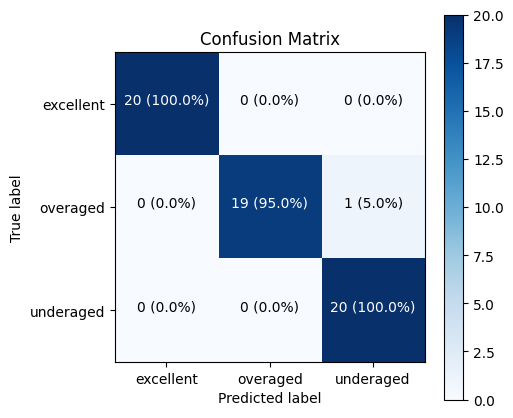

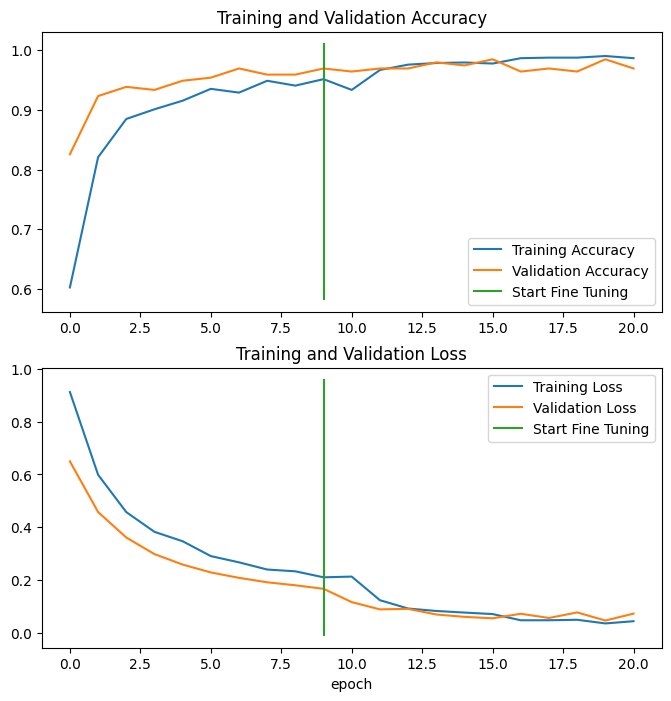

In [23]:
#Generate needed details
generate_details(model_1,test_data,[history1,history1_tuned,10],True)

# Model 2 EfficientNetB0 with augmentation

In [24]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_2.name="Model_2_EfficientNetB0_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

history2 = model_2.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5296 - loss: 1.0170
Epoch 1: val_loss improved from inf to 0.70321, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.5318 - loss: 1.0140 - val_accuracy: 0.7487 - val_loss: 0.7032
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7906 - loss: 0.6860
Epoch 2: val_loss improved from 0.70321 to 0.54559, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.7907 - loss: 0.6850 - val_accuracy: 0.7846 - val_loss: 0.5456
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8101 - loss: 0.5682
Epoch 3: val_loss improved from 0.54559 to 0.46144, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.8101 - loss: 0.5675 - val_accuracy: 0.8256 - val_loss: 0.461

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9243 - loss: 0.2197
done.
Predicting...
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f91bc455d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -5.563100180516756e-08


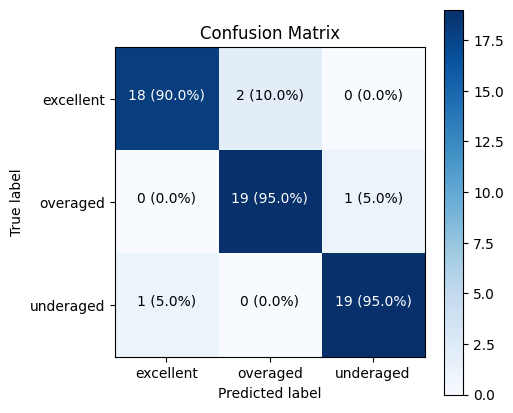

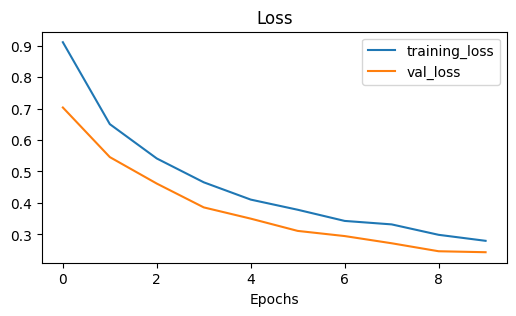

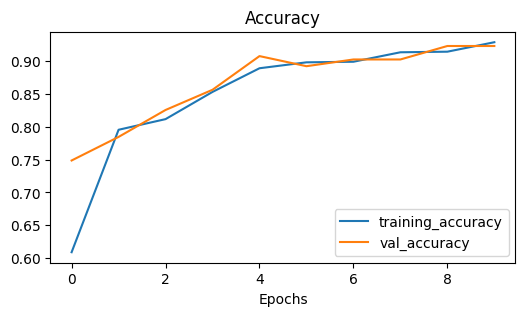

In [25]:
#Generate needed details
generate_details(model_2,test_data,[history2])

# Model 2 EfficientNetB0 with augmentation and fine-tuning

In [26]:
model_2.load_weights(checkpoint_path)
model_2.layers[2].trainable = False

for layer in model_2.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_2.name = "Model_2_EfficientNetB0_with_augmentation_and_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history2_tuned = model_2.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history2.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8864 - loss: 0.3009
Epoch 10: val_loss improved from inf to 0.21191, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - accuracy: 0.8872 - loss: 0.2993 - val_accuracy: 0.9282 - val_loss: 0.2119
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9581 - loss: 0.1475
Epoch 11: val_loss improved from 0.21191 to 0.14055, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.9581 - loss: 0.1474 - val_accuracy: 0.9436 - val_loss: 0.1406
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9763 - loss: 0.1053
Epoch 12: val_loss improved from 0.14055 to 0.09379, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9762 -

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0365
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
done.
Close? True | Difference: -5.960464477539063e-08


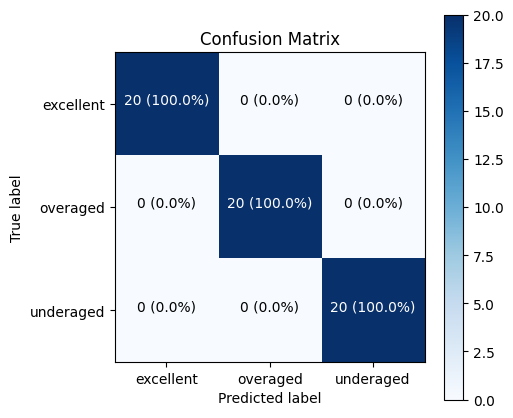

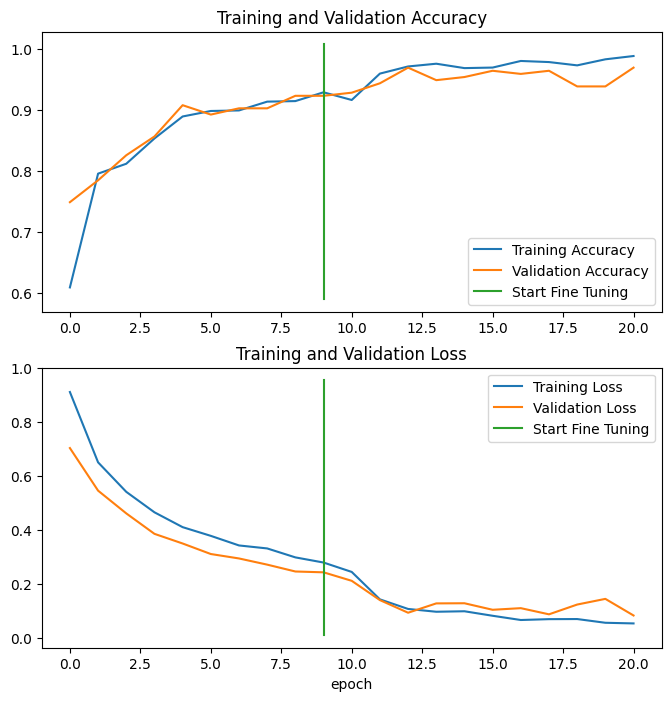

In [27]:
#Generate needed details
generate_details(model_2,test_data,[history2,history2_tuned,10],True)

# Model 3 ResNet50v2

In [28]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = layers.Rescaling(1./255,name="rescaler")(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

history3 = model_3.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4230 - loss: 1.3831
Epoch 1: val_loss improved from inf to 0.65416, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.4250 - loss: 1.3767 - val_accuracy: 0.7385 - val_loss: 0.6542
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6741 - loss: 0.7542
Epoch 2: val_loss improved from 0.65416 to 0.46484, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.6749 - loss: 0.7527 - val_accuracy: 0.8513 - val_loss: 0.4648
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8012 - loss: 0.5111
Epoch 3: val_loss did not improve from 0.46484
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8011 - loss: 0.5110 - val_accuracy: 0.7538 - val_loss: 0.5936
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7285 - loss: 0.6219
Epoch 4: val_loss improved from 0.46484 t

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - accuracy: 0.9556 - loss: 0.1611
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 962ms/step
done.
Close? True | Difference: -5.563100180516756e-08


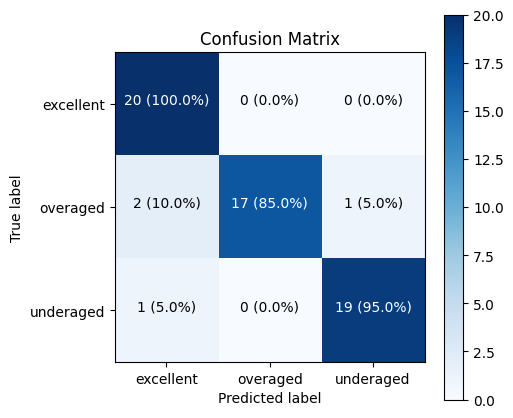

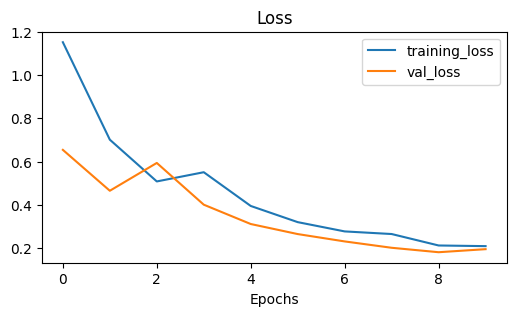

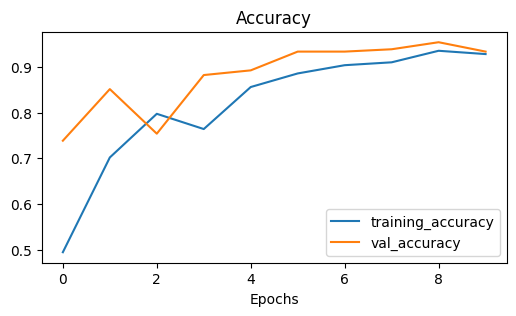

In [29]:
#Generate needed details
generate_details(model_3,test_data,[history3])

# Model 3 ResNet50v2 with fine-tuning

In [30]:
model_3.load_weights(checkpoint_path)
model_3.layers[2].trainable = False

for layer in model_3.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history3_tuned = model_3.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history3.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8938 - loss: 0.3099
Epoch 10: val_loss improved from inf to 0.17151, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.8942 - loss: 0.3085 - val_accuracy: 0.9385 - val_loss: 0.1715
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9697 - loss: 0.0978
Epoch 11: val_loss improved from 0.17151 to 0.08127, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9697 - loss: 0.0975 - val_accuracy: 0.9795 - val_loss: 0.0813
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9858 - loss: 0.0583
Epoch 12: val_loss improved from 0.08127 to 0.05172, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9859 - loss: 0.0581 - val_accuracy: 0.9795 - val_loss: 0.0517
Epoch 1

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3472 - loss: 1.3491
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 950ms/step
done.
Close? True | Difference: -1.986821490662649e-08


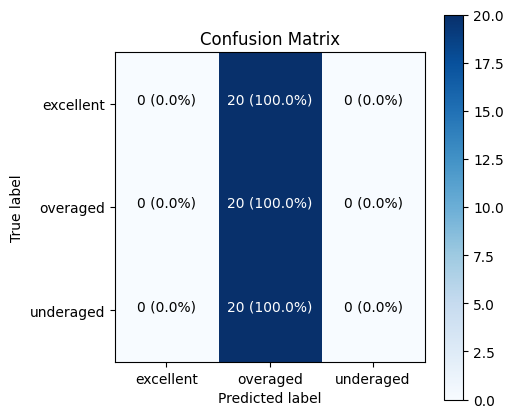

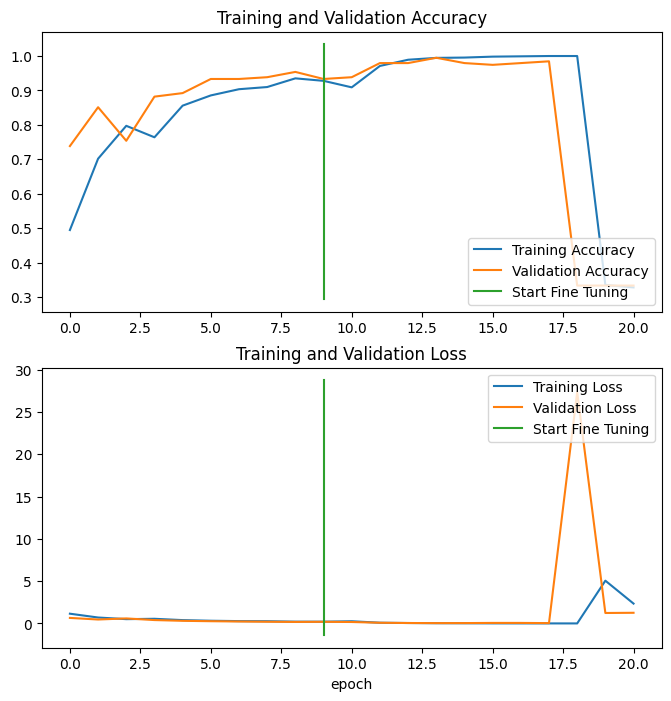

In [31]:
#Generate needed details
generate_details(model_3,test_data,[history3,history3_tuned,10],True)

# Model 4 ResNet50v2 with augmentation

In [32]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")


input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_4 = keras.Model(inputs, outputs)

model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

history4 = model_4.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3987 - loss: 1.5675
Epoch 1: val_loss improved from inf to 0.85297, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.4001 - loss: 1.5600 - val_accuracy: 0.6103 - val_loss: 0.8530
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5900 - loss: 0.8672
Epoch 2: val_loss improved from 0.85297 to 0.55617, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.5908 - loss: 0.8658 - val_accuracy: 0.7949 - val_loss: 0.5562
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7314 - loss: 0.6366
Epoch 3: val_loss improved from 0.55617 to 0.45747, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.7317 - loss: 0.6360 - val_accuracy: 0.8308 - val_loss: 0.4575
Epoch 4/10

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9340 - loss: 0.2202
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 967ms/step
done.
Close? True | Difference: -3.973642981325298e-08


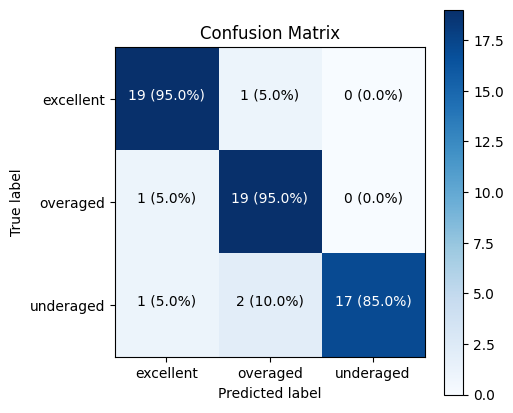

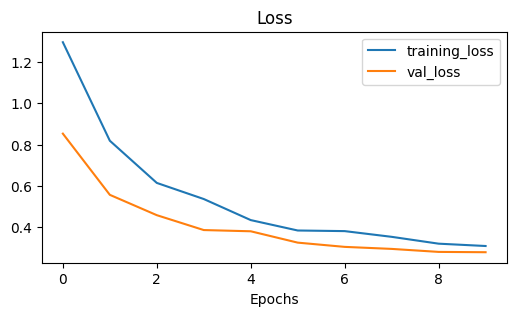

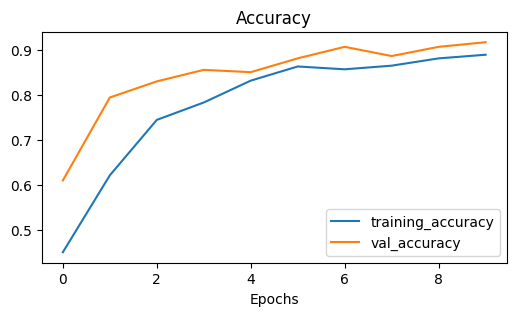

In [33]:
#Generate needed details
generate_details(model_4,test_data,[history4])

# Model 4 ResNet50v2 with augmentation with fine-tuning

In [34]:
model_4.load_weights(checkpoint_path)
model_4.layers[3].trainable = False

for layer in model_4.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history4_tuned = model_4.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history4.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8656 - loss: 0.3567
Epoch 10: val_loss improved from inf to 0.21868, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.8656 - loss: 0.3568 - val_accuracy: 0.9231 - val_loss: 0.2187
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9439 - loss: 0.1906
Epoch 11: val_loss did not improve from 0.21868
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9433 - loss: 0.1912 - val_accuracy: 0.9077 - val_loss: 0.2746
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8799 - loss: 0.2981
Epoch 12: val_loss did not improve from 0.21868
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.8803 - loss: 0.2974 - val_accuracy: 0.9026 - val_loss: 0.2707
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9126 - loss: 0.2033
Epoch 13: val_loss improved from 0.21868 to 0.19189, saving mo

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9451 - loss: 0.1593
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 922ms/step
done.
Close? True | Difference: -5.563100180516756e-08


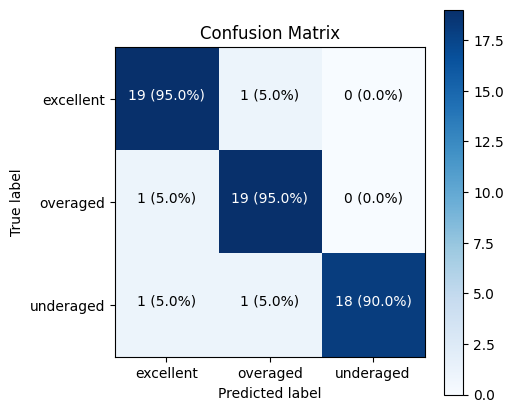

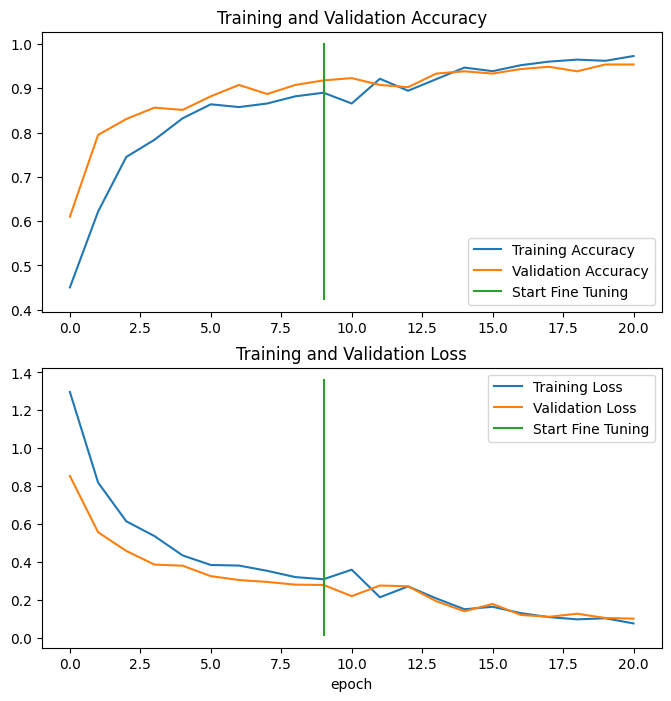

In [35]:
#Generate needed details
generate_details(model_4,test_data,[history4,history4_tuned,10],True)

# Model 5 VGG16

In [36]:
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = layers.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(x)
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_5 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

history5 = model_5.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3585 - loss: 1.1018
Epoch 1: val_loss improved from inf to 1.08512, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.3586 - loss: 1.1017 - val_accuracy: 0.3538 - val_loss: 1.0851
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4176 - loss: 1.0816
Epoch 2: val_loss improved from 1.08512 to 1.07225, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4185 - loss: 1.0815 - val_accuracy: 0.4051 - val_loss: 1.0723
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4412 - loss: 1.0658
Epoch 3: val_loss improved from 1.07225 to 1.06382, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.4414 - loss: 1.0658 - val_accuracy: 0.4308 - val_loss: 1.0638
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4349 - loss: 1

In [37]:
model_5.summary()

Model: "Model_5_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,307 (56.15 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,080 (12.04 KB)

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6618 - loss: 0.9635
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
done.
Close? True | Difference: -7.947285940446136e-09


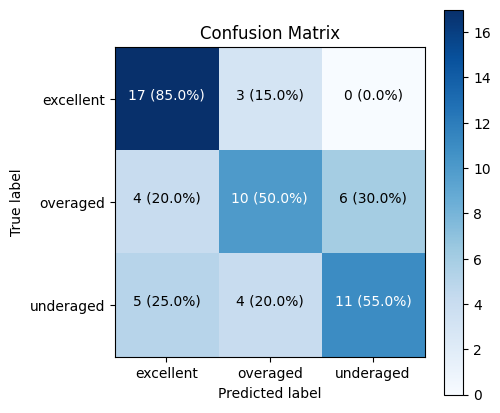

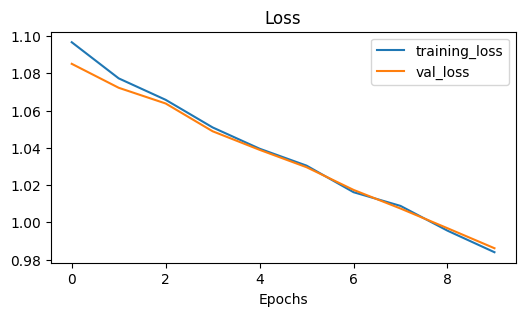

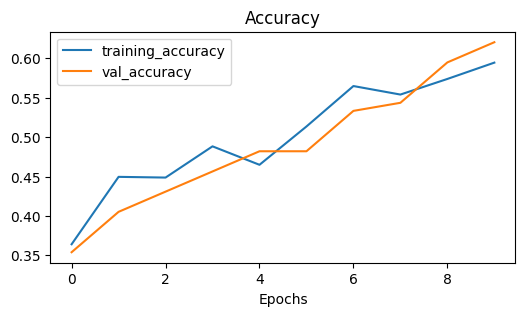

In [38]:
#Generate needed details
generate_details(model_5,test_data,[history5])

# Model 5 VGG16 with fine-tuning

In [39]:
model_5.load_weights(checkpoint_path)
model_5.layers[2].trainable = False

for layer in model_5.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history5_tuned = model_5.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history5.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.4507 - loss: 1.0960
Epoch 10: val_loss improved from inf to 0.79329, saving model to checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.4522 - loss: 1.0936 - val_accuracy: 0.6462 - val_loss: 0.7933
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7658 - loss: 0.5530
Epoch 11: val_loss improved from 0.79329 to 0.24549, saving model to checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.7670 - loss: 0.5501 - val_accuracy: 0.9128 - val_loss: 0.2455
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9101 - loss: 0.2225
Epoch 12: val_loss did not improve from 0.24549
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.9105 - loss: 0.2218 - val_accuracy: 0.8308 - val_loss: 0.4989
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9579 - loss: 0.1233
Epoch 13: 

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9785 - loss: 0.0230
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
done.
Close? True | Difference: -4.371007278347605e-08


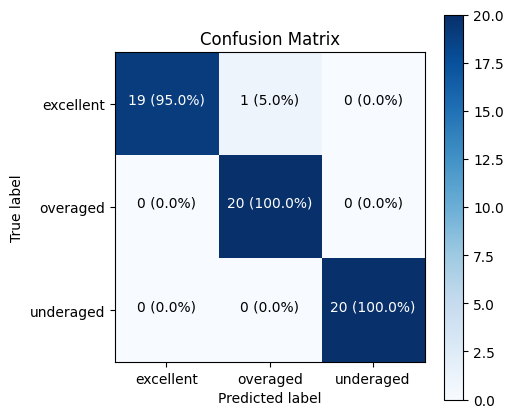

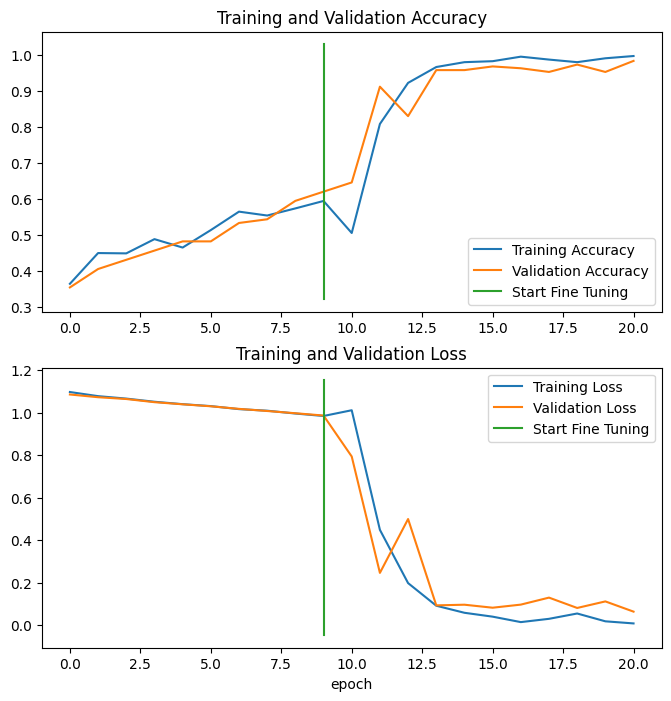

In [40]:
#Generate needed details
generate_details(model_5,test_data,[history5,history5_tuned,10],True)

# Model 6 VGG16 with augmentation

In [41]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_6 = keras.Model(inputs, outputs)

model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_6.name = "Model_6_VGG16_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

history6 = model_6.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3186 - loss: 1.1610
Epoch 1: val_loss improved from inf to 1.10098, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.3182 - loss: 1.1603 - val_accuracy: 0.3846 - val_loss: 1.1010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3672 - loss: 1.1015
Epoch 2: val_loss improved from 1.10098 to 1.08844, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.3669 - loss: 1.1015 - val_accuracy: 0.5128 - val_loss: 1.0884
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3641 - loss: 1.0860
Epoch 3: val_loss improved from 1.08844 to 1.08092, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.3645 - loss: 1.0861 - val_accuracy: 0.3436 - val_loss: 1.0809
Epoch 4/10
35/35 ━━━━━━━━━

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4799 - loss: 1.0224
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
done.
Close? True | Difference: -1.5894571991914574e-08


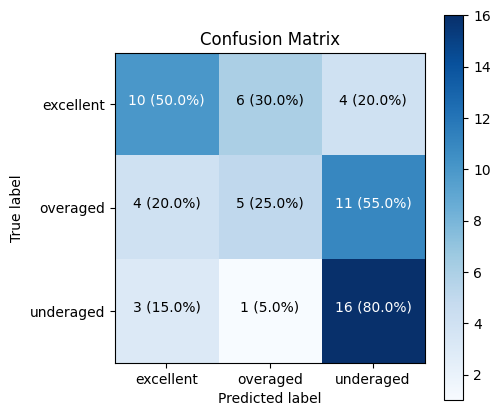

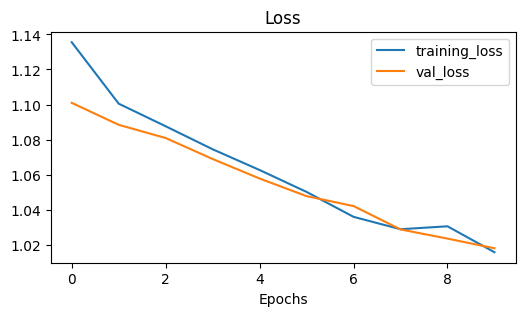

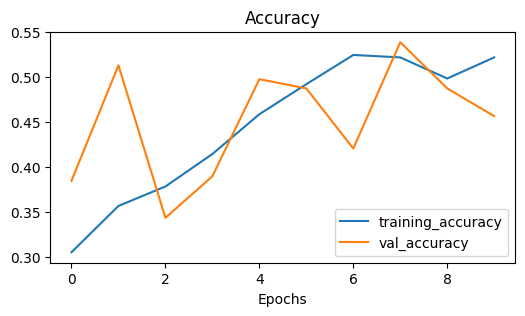

In [42]:
#Generate needed details
generate_details(model_6,test_data,[history6])

# Model 6 VGG16 with augmentation and fine-tuning

In [43]:
model_6.load_weights(checkpoint_path)
model_6.layers[3].trainable = False

for layer in model_6.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate
              metrics=["accuracy"])

model_6.name = "Model_6_VGG16_with_augmentation_and_fine-tuningn"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history6_tuned = model_6.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history6.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5228 - loss: 1.0467
Epoch 10: val_loss improved from inf to 0.39402, saving model to checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.5254 - loss: 1.0409 - val_accuracy: 0.8359 - val_loss: 0.3940
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8404 - loss: 0.3707
Epoch 11: val_loss improved from 0.39402 to 0.13939, saving model to checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.8416 - loss: 0.3685 - val_accuracy: 0.9538 - val_loss: 0.1394
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9591 - loss: 0.1273
Epoch 12: val_loss did not improve from 0.13939
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.9591 - loss: 0.1273 - val_accuracy: 0.8410 - val_loss: 0.3595
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accura

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9785 - loss: 0.0313
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
done.
Close? True | Difference: -4.371007278347605e-08


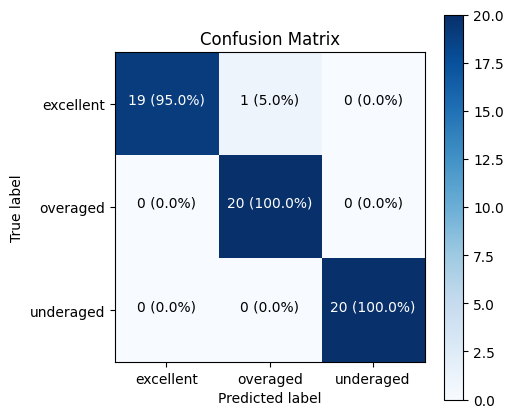

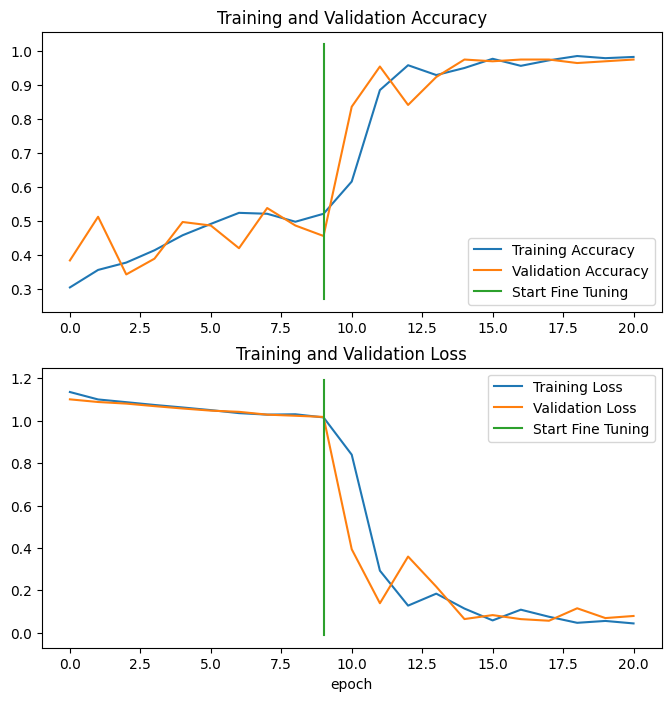

In [44]:
#Generate needed details
generate_details(model_6,test_data,[history6,history6_tuned,10],True)

# RESULT SUMMARY

In [45]:
show_results(res)

,Model,Loss,Accuracy
0,Model_1_EfficientNetB0,15.9091,98.3333
1,Model_1_EfficientNetB0_with_fine-tuning,3.7840,98.3333
2,Model_2_EfficientNetB0_with_augmentation,23.1754,93.3333
3,Model_2_EfficientNetB0_with_augmentation_and_f...,2.9390,100.0000
4,Model_3_ResNet50v2,17.8536,93.3333
5,Model_3_ResNet50v2_with_fine-tuning,126.0068,33.3333
6,Model_4_ResNet50v2_with_augmentation,25.9048,91.6667
7,Model_4_ResNet50v2_with_augmentation_with_fine...,20.6754,93.3333
8,Model_5_VGG16,96.3728,63.3333
9,Model_5_VGG16_with_fine-tuning,2.0422,98.3333
